# Соревнование Kaggle "Классификация фотографий бабочек"

## 1. Описание задачи и данные

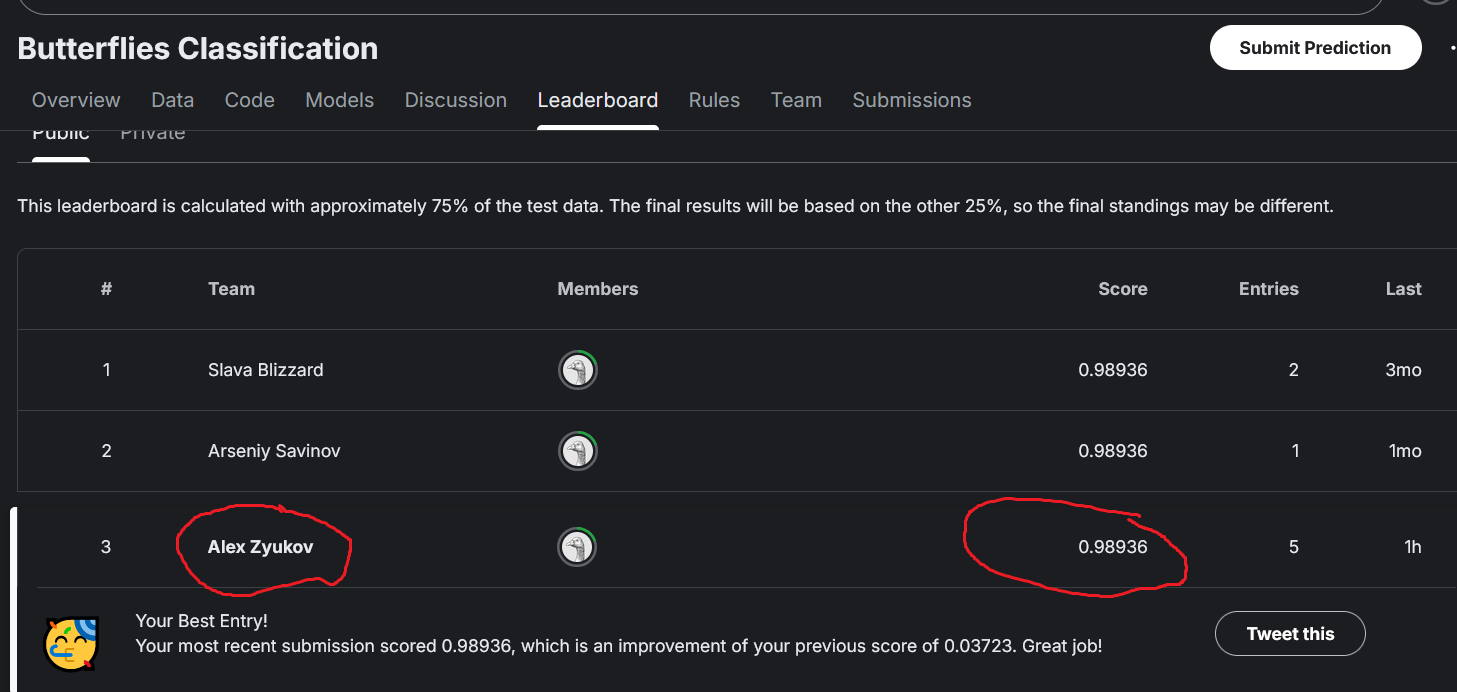

В рамках соревнования необходимо решить задачу классификации фотографий бабочек на 50 классов. Каждая фотография представляет из себя цветное изображение размера 224×224.

Даны два набора данных:

- Папка train содержит в себе 50 папок, разбитых на классы. Всего порядка 5000 фото.
- Папка test содержит в себе 250 фотографий, которые необходимо классифицировать.
- Используется метрика accuracy.

Ссылка на соревнование и на данные: https://www.kaggle.com/competitions/butterflies-classification

In [ ]:
# Установим библиотеку для работы с датасетами на kaggle
!pip install opendatasets --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import opendatasets as od

In [ ]:
# Подгружаем датасет
url = 'https://www.kaggle.com/competitions/butterflies-classification'
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alexzyukov
Your Kaggle Key: ··········


100%|██████████| 132M/132M [00:00<00:00, 1.18GB/s]


Extracting archive ./butterflies-classification/butterflies-classification.zip to ./butterflies-classification


## 1. Предварительное исследование данных

- Определяем баланс изображений внутри классов
- Описываем особенности датасета
- Оцениваем, нужна ли очистка и предобработка данных

In [ ]:
import os
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms, io, utils, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [ ]:
HOME_DIR = './butterflies-classification/'
TRAIN_DIR = HOME_DIR + 'train_butterflies/train_split'
TEST_DIR = HOME_DIR + 'test_butterflies/valid/'

# Подгружаем размеченные данные
base_ds = ImageFolder(root=TRAIN_DIR)

classes = base_ds.classes
classidx = base_ds.class_to_idx
counts = Counter(base_ds.targets)

# 50 видов бабочек
print(classes)

counts_df = pd.Series(counts).sort_index().rename({
    i: classes[i] for i in range(len(classes))
})
counts_vals = np.array(list(counts.values()))

# картинки распределены неравномерно по категориям,
# в каждой mean=99, std=15
#print(counts_df)
print(np.mean(counts_vals), np.std(counts_vals))

widths, heights = set(), set()
num_images = 0
for root, _, files in os.walk(TRAIN_DIR):
    for fname in files:
        path = os.path.join(root, fname)
        with Image.open(path) as img:
            w, h = img.size
            widths.add(w)
            heights.add(h)
        num_images += 1

# все картинки в разрешении 224x224
print(widths, heights)

# всего 4955 картинок
print(num_images)

"""
Особенности датасета:

1. У бабочки могут быть сложены или раскрыты
крылья — задача классификации усложняется,
нейросеть может ошибчно учитывать количество
крыльев, которые видны: одно или два.

2. Окрас и рисунок на разных сторонах крыльев
может быть разный. Поэтому изображения могут
значительно различаться даже внутри классов.
Например, в class_10 это серый и бурый цвета.

3. Бабочки расположены под разными углами
и ракурсами, яркость картинок также различается.
Значит, уместна соответствующая аугментация

4. У картинок есть фон, в основном это зелень.
Стоит его исключать, чтобы он не мешал
классификации бабочек. То есть это задача
сегментации, можно использовать простые
пороговые методы

5. Датасет несбалансирован, как выяснили в
коде выше. Картинок одних классов ~70,
а других — ~130

6. Отдельного упоминания требует class_39.
Он содержит картинки, на которых бабочки
напоминают небольших жуков. Причём бабочки
эти много меньше цветков, на которых
они запечатлены. Нейросеть может ошибочно
классифицировать фотографии с цветами как
экземпляры class_39

7. Цвет важен при классификации бабочек,
поэтому лучше не аугментировать по нему

Без аугментации и сегментации нейросеть
показывает accuracy на тесте, близкое 
к 100%
"""

['class_0', 'class_1', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14', 'class_15', 'class_16', 'class_17', 'class_18', 'class_19', 'class_2', 'class_20', 'class_21', 'class_22', 'class_23', 'class_24', 'class_25', 'class_26', 'class_27', 'class_28', 'class_29', 'class_3', 'class_30', 'class_31', 'class_32', 'class_33', 'class_34', 'class_35', 'class_36', 'class_37', 'class_38', 'class_39', 'class_4', 'class_40', 'class_41', 'class_42', 'class_43', 'class_44', 'class_45', 'class_46', 'class_47', 'class_48', 'class_49', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
99.1 15.121177202850312
{224} {224}
4955


'\nОсобенности датасета:\n\n1. У бабочки могут быть сложены или раскрыты\nкрылья — задача классификации усложняется,\nнейросеть может ошибчно учитывать количество\nкрыльев, которые видны: одно или два.\n\n2. Окрас и рисунок на разных сторонах крыльев\nможет быть разный. Поэтому изображения могут\nзначительно различаться даже внутри классов.\nНапример, в class_10 это серый и бурый цвета.\n\n3. Бабочки расположены под разными углами\nи ракурсами, яркость картинок также различается.\nЗначит, уместна соответствующая аугментация\n\n4. У картинок есть фон, в основном это зелень.\nСтоит его исключать, чтобы он не мешал\nклассификации бабочек. То есть это задача\nсегментации, можно использовать простые\nпороговые методы\n\n5. Датасет несбалансирован, как выяснили в\nкоде выше. Картинок одних классов ~70,\nа других — ~130\n\n6. Отдельного упоминания требует class_39.\nОн содержит картинки, на которых бабочки\nнапоминают небольших жуков. Причём бабочки\nэти много меньше цветков, на которых\nони 

## 2. Подготовка данных для обучения

- Создать тренировочную и тестовую подвыборки для обучения и тестирования работы моделей
- Создать класс на фреймворке `PyTorch` для создания датасета
- Создать `loader` для передачи данных в модель нейронной сети

In [ ]:
class MyDataset(Dataset):
    def __init__(self, path, labels, transform=None):
        self.paths = np.array(path)
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [ ]:
samples = base_ds.samples
paths, labels = zip(*samples)

# Разделили размеченные данные на тренировочную и тестовую выборки
# stratify=labels для равномерности количества экземпляров по классам
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    paths, labels, test_size=0.2, stratify=labels
)

# Трансформация для использования нейросетей на основе ImageNet
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Такая же трансформация, что и для теста.
# Две переменные заведены, для более
# удобной аугментации, но в итоге она
# значительно не повышала точность
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_data = MyDataset(train_paths, train_labels, transform=train_transform)
valid_data = MyDataset(valid_paths, valid_labels, transform=train_transform)

# перемешивание shuffle=True, чтобы нейросеть не запоминала
# порядок индексов в тренировочной выборке
train_loader = DataLoader(
    train_data, batch_size=32, shuffle=True, num_workers=2
)
valid_loader = DataLoader(
    valid_data, batch_size=32, shuffle=False, num_workers=2
)

## 3. Реализация модели

- Создать класс для модели
- Создать функцию для обучения модели
- Создать функцию для валидации модели

In [ ]:
# Используем предобученную свёрточную нейронную сеть типа ImageNet
class RSNAModel(nn.Module):
    def __init__(self, num_classes, backbone_name='resnet18'):
        super().__init__()

        if backbone_name == 'resnet18':
            self.backbone = models.resnet18(pretrained=True)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(in_features, num_classes)
        elif backbone_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(in_features, num_classes)
        elif backbone_name == 'efficientnet_b0':
            self.backbone = models.efficientnet_b0(pretrained=True)
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier[1] = nn.Linear(in_features, num_classes)
        else:
            raise ValueError(f'Unknown nn: {backbone_name}')

    def forward(self, batch):
        return self.backbone(batch)

In [ ]:
def train_one_epoch(
    model,
    train_dataloader,
    optimizer,
    loss_fn,
    epoch,
    device,
    log_wandb=False,
    verbose=False
):
    model.train()

    # Инициализируем счётчики потерь, правильных предсказаний
    # и числа образцов
    running_loss = 0
    running_corrects = 0
    total_samples = 0

    # Свой прогресс-бар через tqdm для батчей
    pbar = tqdm(
        enumerate(train_dataloader),
        total=len(train_dataloader),
        desc=f'train epoch: {epoch}'
    )

    for batch_idx, (inputs, labels) in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Обнуляем градиенты, обратное распр. ошибки и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Считаем метрики
        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total_samples += inputs.size(0)

        # Выводим результаты
        if verbose:
            pbar.set_postfix({
                'train_loss': f'{running_loss/total_samples:.4f}',
                'train_acc': f'{running_corrects/total_samples:.4f}'
            })

    epoch_loss = running_loss / total_samples
    epoch_accuracy = running_corrects / total_samples

    return epoch_loss, epoch_accuracy


# Аналогично
@torch.no_grad()
def valid_one_epoch(
    model,
    valid_dataloader,
    loss_fn,
    epoch,
    device,
    log_wandb=False,
    verbose=False
):
    model.eval()

    running_loss = 0
    running_corrects = 0
    total_samples = 0

    pbar = tqdm(
        enumerate(valid_dataloader),
        total=len(valid_dataloader),
        desc=f'valid epoch: {epoch}'
    )

    for batch_idx, (inputs, labels) in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        total_samples += inputs.size(0)

        if verbose:
            pbar.set_postfix({
                'val_loss': f'{running_loss/total_samples:.4f}',
                'val_acc': f'{running_corrects/total_samples:.4f}'
            })

    epoch_loss = running_loss / total_samples
    epoch_accuracy = running_corrects / total_samples

    return epoch_loss, epoch_accuracy

## 4. Обучение модели
*   Определяем гиперпараметры модели
*   Обучаем модель
*   Оцениваем эффективность её работы 



In [ ]:
# Гиперпараметры
NUM_CLASSES = 50
LR = 1e-4
EPOCHS = 5
DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Модель
model = RSNAModel(num_classes=NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss() # задача классификации
optimizer = Adam(model.parameters(), lr=LR)

# Цикл обучения
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, loss_fn, epoch, DEVICE
    )
    valid_loss, valid_acc = valid_one_epoch(
        model, valid_loader, loss_fn, epoch, DEVICE
    )
    print(
        f'epoch: {epoch:02d}, train_loss={train_loss:.4f}, '
        f'train_acc={train_acc:.4f}, valid_loss={valid_loss:.4f}, '
        f'valid_acc={valid_acc:.4f}'
    )

"""
ResNet18 достаточно быстро переобучается: train_acc=0.9990,
loss на тренировочной выборке в 10 раз меньше, чем на
валидации. С валидацией справляется достаточно хорошо,
точность 0.9435
"""

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]
valid epoch: 1: 100%|██████████| 31/31 [00:02<00:00, 11.79it/s]

epoch: 01, train_loss=1.6089, train_acc=0.6920, valid_loss=0.4748, valid_acc=0.9132



valid epoch: 2: 100%|██████████| 31/31 [00:02<00:00, 13.56it/s]

epoch: 02, train_loss=0.2948, train_acc=0.9543, valid_loss=0.3239, valid_acc=0.9425



valid epoch: 3: 100%|██████████| 31/31 [00:01<00:00, 15.65it/s]

epoch: 03, train_loss=0.1153, train_acc=0.9841, valid_loss=0.2683, valid_acc=0.9455



valid epoch: 4: 100%|██████████| 31/31 [00:01<00:00, 15.70it/s]

epoch: 04, train_loss=0.0484, train_acc=0.9962, valid_loss=0.2527, valid_acc=0.9465



valid epoch: 5: 100%|██████████| 31/31 [00:01<00:00, 16.33it/s]

epoch: 05, train_loss=0.0290, train_acc=0.9990, valid_loss=0.2578, valid_acc=0.9516


'\nResNet18 достаточно быстро переобучается: train_acc=0.9990,\nloss на тренировочной выборке в 10 раз меньше, чем на\nвалидации. С валидацией справляется достаточно хорошо,\nточность 0.9435\n'

## 5. Выбор наилучшей модели 

- Тестируем 3 разных модели для решения задачи
- Сравниваем их эффективность (по метрикам и потерям)
- Анализируем результат

In [ ]:
model_names = ['resnet18', 'resnet50', 'efficientnet_b0']
results = []

for name in model_names:
    print(f'--- Training model: {name} ---')
    model = RSNAModel(num_classes=NUM_CLASSES, backbone_name=name).to(DEVICE)
    optimizer = Adam(model.parameters(), lr=LR)


    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, loss_fn, epoch, DEVICE
        )
        valid_loss, valid_acc = valid_one_epoch(
            model, valid_loader, loss_fn, epoch, DEVICE
        )
        print(
            f'{name} | epoch {epoch:02d} | '
            f'train_acc: {train_acc:.4f} | val_acc: {valid_acc:.4f}'
        )

    results.append((name, train_acc, valid_acc))

--- Training model: resnet18 ---


valid epoch: 1: 100%|██████████| 31/31 [00:01<00:00, 15.77it/s]

resnet18 | epoch 01 | train_acc: 0.6907 | val_acc: 0.8991



valid epoch: 2: 100%|██████████| 31/31 [00:02<00:00, 13.80it/s]

resnet18 | epoch 02 | train_acc: 0.9596 | val_acc: 0.9162



valid epoch: 3: 100%|██████████| 31/31 [00:03<00:00, 10.20it/s]

resnet18 | epoch 03 | train_acc: 0.9886 | val_acc: 0.9273



valid epoch: 4: 100%|██████████| 31/31 [00:03<00:00,  9.38it/s]

resnet18 | epoch 04 | train_acc: 0.9952 | val_acc: 0.9364



valid epoch: 5: 100%|██████████| 31/31 [00:02<00:00, 12.67it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet18 | epoch 05 | train_acc: 0.9972 | val_acc: 0.9354
--- Training model: resnet50 ---


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]
valid epoch: 1: 100%|██████████| 31/31 [00:03<00:00,  8.38it/s]

resnet50 | epoch 01 | train_acc: 0.7144 | val_acc: 0.9082



valid epoch: 2: 100%|██████████| 31/31 [00:03<00:00,  9.24it/s]

resnet50 | epoch 02 | train_acc: 0.9445 | val_acc: 0.9314



valid epoch: 3: 100%|██████████| 31/31 [00:03<00:00,  8.08it/s]

resnet50 | epoch 03 | train_acc: 0.9806 | val_acc: 0.9536



valid epoch: 4: 100%|██████████| 31/31 [00:03<00:00,  9.25it/s]

resnet50 | epoch 04 | train_acc: 0.9902 | val_acc: 0.9374



valid epoch: 5: 100%|██████████| 31/31 [00:03<00:00,  9.26it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


resnet50 | epoch 05 | train_acc: 0.9960 | val_acc: 0.9455
--- Training model: efficientnet_b0 ---


100%|██████████| 20.5M/20.5M [00:00<00:00, 196MB/s]
valid epoch: 1: 100%|██████████| 31/31 [00:02<00:00, 12.78it/s]

efficientnet_b0 | epoch 01 | train_acc: 0.4465 | val_acc: 0.8022



valid epoch: 2: 100%|██████████| 31/31 [00:02<00:00, 15.06it/s]

efficientnet_b0 | epoch 02 | train_acc: 0.8436 | val_acc: 0.9142



valid epoch: 3: 100%|██████████| 31/31 [00:02<00:00, 11.91it/s]

efficientnet_b0 | epoch 03 | train_acc: 0.9200 | val_acc: 0.9294



valid epoch: 4: 100%|██████████| 31/31 [00:02<00:00, 11.16it/s]

efficientnet_b0 | epoch 04 | train_acc: 0.9488 | val_acc: 0.9405



valid epoch: 5: 100%|██████████| 31/31 [00:02<00:00, 14.75it/s]

efficientnet_b0 | epoch 05 | train_acc: 0.9647 | val_acc: 0.9455


In [ ]:
df_results = pd.DataFrame(results, columns=['model', 'train_acc', 'valid_acc'])
df_sorted = df_results.sort_values('valid_acc', ascending=False).reset_index(drop=True)
df_sorted

,model,train_acc,valid_acc
0,resnet50,0.995964,0.945510
1,efficientnet_b0,0.964682,0.945510
2,resnet18,0.997225,0.935419


In [ ]:
"""
Сравним нейросети:

ResNet50 самая медленная, зато с высокой валидационной точностью.
Имеет много параметров. valid_loss = 0.02, train_loss=0.17,
то есть хорошо сходится

EfficientNet-B0 более простая, но по валидации как ResNet50.
train_loss=0.05, valid_loss как у ResNet50

ResNet18 самая быстрая, но слишком быстро запоминает train:
точность на тренировочной выборке 0.9995, низкий train_loss,
то есть явное переобучение. Валидационная точность чуть хуже,
чем у других моделей

*значения для случая, если в train_test_split задали seed=42.
Иногда EfficientNet-B0 показывает наиболее стабильный результат:
не переобучается и показывает наибольшую точность на valid
"""

'\nСравним нейросети:\n\nResNet50 самая медленная, зато с высокой валидационной точностью.\nИмеет много параметров. valid_loss = 0.02, train_loss=0.17,\nто есть хорошо сходится\n\nEfficientNet-B0 более простая, но по валидации как ResNet50.\ntrain_loss=0.05, valid_loss как у ResNet50\n\nResNet18 самая быстрая, но слишком быстро запоминает train:\nточность на тренировочной выборке 0.9995, маленький train_loss,\nто есть явное переобучение. Валидационная точность чуть хуже,\nчем у других моделей\n\n*значения для случая, если в train_test_split задали seed=42.\nИногда EfficientNet-B0 показывает наиболее стабильный результат:\nне переобучается и показывает наибольшую точность на valid\n'

# 6. Тест на Kaggle

- Реализуем класс датасета с тестовыми данными для соревнования
- Применяем лучшую из обученных моделей для классификации
- Отправляем результаты в систему проверок Kaggle

In [ ]:
class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.paths = sorted(
            [
                os.path.join(path, fname)
                for fname in os.listdir(path)
            ],
            key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
        )
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img

In [ ]:
test_data = TestDataset(TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
@torch.no_grad()
def predict(model, dataloader, device):
    model.eval()
    preds = []

    for batch in tqdm(dataloader):
        batch = batch.to(device)
        outputs = model(batch)
        batch_preds = outputs.argmax(dim=1).cpu().numpy()
        preds.extend(batch_preds)

    return preds

In [ ]:
# Используем ResNet50 как лучшую на valid среди протестированных нейросетей.
# Обучаем 10 эпох, что долго, зато добиваемся наилучших весов и сохраняем их
model = RSNAModel(num_classes=NUM_CLASSES, backbone_name='resnet50').to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

best_acc = 0.0

for epoch in range(1, 10 + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, loss_fn, epoch, DEVICE
    )
    valid_loss, valid_acc = valid_one_epoch(
        model, valid_loader, loss_fn, epoch, DEVICE
    )
    print(
        f'epoch: {epoch:02d}, train_loss={train_loss:.4f}, '
        f'train_acc={train_acc:.4f}, valid_loss={valid_loss:.4f}, '
        f'valid_acc={valid_acc:.4f}'
    )

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')

# Наилучшие веса сохранены в файл best_model.pth

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
valid epoch: 1: 100%|██████████| 31/31 [00:03<00:00,  9.03it/s]


epoch: 01, train_loss=1.4027, train_acc=0.7288, valid_loss=0.3538, valid_acc=0.9173


valid epoch: 2: 100%|██████████| 31/31 [00:03<00:00,  9.38it/s]


epoch: 02, train_loss=0.2108, train_acc=0.9518, valid_loss=0.2312, valid_acc=0.9415


valid epoch: 3: 100%|██████████| 31/31 [00:03<00:00,  8.96it/s]

epoch: 03, train_loss=0.0984, train_acc=0.9778, valid_loss=0.2363, valid_acc=0.9354



valid epoch: 4: 100%|██████████| 31/31 [00:03<00:00,  9.03it/s]

epoch: 04, train_loss=0.0446, train_acc=0.9909, valid_loss=0.2408, valid_acc=0.9364



valid epoch: 5: 100%|██████████| 31/31 [00:03<00:00,  9.26it/s]

epoch: 05, train_loss=0.0272, train_acc=0.9952, valid_loss=0.2499, valid_acc=0.9415



valid epoch: 6: 100%|██████████| 31/31 [00:03<00:00,  9.37it/s]

epoch: 06, train_loss=0.0311, train_acc=0.9929, valid_loss=0.2846, valid_acc=0.9395



valid epoch: 7: 100%|██████████| 31/31 [00:03<00:00,  8.31it/s]


epoch: 07, train_loss=0.0220, train_acc=0.9970, valid_loss=0.2700, valid_acc=0.9485


valid epoch: 8: 100%|██████████| 31/31 [00:03<00:00,  8.54it/s]

epoch: 08, train_loss=0.0219, train_acc=0.9957, valid_loss=0.3477, valid_acc=0.9243



valid epoch: 9: 100%|██████████| 31/31 [00:04<00:00,  7.68it/s]

epoch: 09, train_loss=0.0693, train_acc=0.9823, valid_loss=0.5689, valid_acc=0.8708



valid epoch: 10: 100%|██████████| 31/31 [00:03<00:00,  9.24it/s]

epoch: 10, train_loss=0.0574, train_acc=0.9859, valid_loss=0.3077, valid_acc=0.9294


In [ ]:
# Предсказываем test, то есть 250 неразмеченных картинок
model.load_state_dict(torch.load('best_model.pth'))
model.to(DEVICE)
test_preds = predict(model, test_loader, DEVICE)

100%|██████████| 8/8 [00:01<00:00,  6.67it/s]


In [ ]:
# "Индексы" файлов в тесте. По сути список 0, ..., 249,
# но реализация более обобщённая
test_file_ids = [
    int(os.path.splitext(os.path.basename(p))[0])
    for p in test_data.paths
]

# Сопоставляем class_XX и XX
class_names = base_ds.classes
test_labels = [
    int(class_names[idx].split('_')[1])
    for idx in test_preds
]

results = pd.DataFrame({
    'index': test_file_ids,
    'label': test_labels
})

# Сохраняем предсказания в файл для Kaggle
results.to_csv('submission.csv', index=False)
print(results.head())

   index  label
0      0     14
1      1     40
2      2      8
3      3     37
4      4     27


In [ ]:
!kaggle competitions submit butterflies-classification -f submission.csv -m "My submission"

100% 1.56k/1.56k [00:00<00:00, 2.00kB/s]
Successfully submitted to Butterflies Classification